### Imports

In [511]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

### 1. Leer Data

Se leen las coordenadas del gps como un Dataframe

In [512]:
gps = pd.read_csv('../data/vehicle_gps.csv')
gps['timestamp'] = pd.to_datetime(gps['timestamp'])
gps 

,vehicle,latitude,longitude,timestamp
0,A,-33.416709,-70.592693,2022-01-01 08:01:00
1,A,-33.417425,-70.592487,2022-01-01 08:02:00
2,A,-33.417831,-70.592367,2022-01-01 08:04:00
3,A,-33.417879,-70.592018,2022-01-01 08:05:00
4,A,-33.417818,-70.591653,2022-01-01 08:06:00
...,...,...,...,...
72,D,-33.419257,-70.586876,2022-01-01 08:22:00
73,D,-33.418902,-70.587003,2022-01-01 08:23:00
74,D,-33.418350,-70.587149,2022-01-01 08:23:00
75,D,-33.417943,-70.587252,2022-01-01 08:24:00


Donde vemos el vehiculo con sus respectivas coordenadas y tiempos.

### 2. Generar y Visualizar Grafos

Generemos un grafo para cada uno de los vehiculos

In [513]:
# Diccionario con grafos
graph_dic = {}

for index, (group,fname) in enumerate(gps.groupby('vehicle')):
    # Dataframe de cada vehiculo
    data = fname

    # Grafo inicial
    G = nx.Graph()

    # Agregar los respectivos nodos
    for i, row in data.iterrows():
        G.add_node(i, pos=(row['latitude'], row['longitude']), label = group)

    # Agregar las aristas con sus distancias y tiempos
    for i, row in data.iloc[:-1].iterrows():
        pos_u = G.nodes[i]['pos']
        pos_v = G.nodes[i+1]['pos']
        distance = ((pos_u[0]-pos_v[0])**2 + (pos_u[1]-pos_v[1])**2)**0.5
        time = (data.loc[i+1,'timestamp'] - data.loc[i,'timestamp']).total_seconds()
        G.add_edge(i, i+1, weight=distance, time = time)

    # Guardar grafo en el diccionario
    graph_dic[group] = G

Ahora que tenemos los distintos grafos podemos visualizarlos

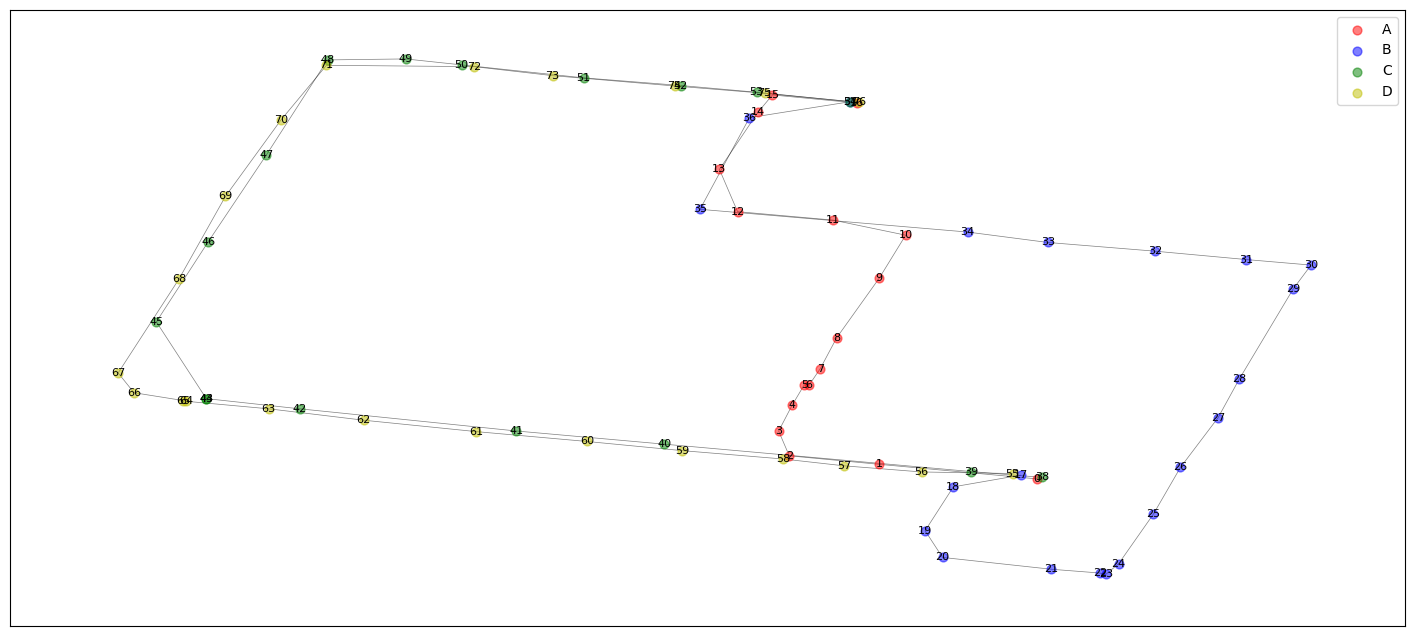

In [514]:
# Lista de colores para cada vehiculo
node_colors = ['r','b','g','y']

plt.figure(figsize=(18, 8))   
for i, (key,value) in enumerate(graph_dic.items()):
    # Set node positions based on their longitude and latitude
    pos = nx.get_node_attributes(value, 'pos')

    nx.draw_networkx_nodes(value, pos, node_size=40,  node_color=node_colors[i], alpha=0.5, label=key)
    nx.draw_networkx_labels(value, pos, labels={node: node for node in value.nodes()}, font_size=8, font_color='k')
    nx.draw_networkx_edges(value, pos, width=0.5, alpha=0.5)

plt.legend(scatterpoints = 1)
plt.show()

Donde se observan 4 grafos que no estan conectados, para ellos generaremos un solo grafo que contenga los 4.

In [515]:
# Grafo combinado 
combined_graph = nx.compose_all(list(graph_dic.values()))

Luego generamos una función que permita encontrar los nodos que se encuentren dentro de un radio pero con label distinto, es decir, de vehiculo distinto con el fin de unir los grafos.

In [516]:
def get_nodes_within_radius(G, node1, radius):
    nodes_within_radius = {}

    # Ubicación y label node 1
    pos1 = nx.get_node_attributes(G, 'pos')[node1]
    lab1 = G.nodes[node1]['label']

    # Recorrer el resto de los nodos
    for node2, pos2 in nx.get_node_attributes(G, 'pos').items():

        # Label node 2
        lab2 = G.nodes[node2]['label']

        # Solo revisar los nodos de distinto label
        if lab1 != lab2:
            distance = ((pos1[0]-pos2[0])**2 + (pos1[1]-pos2[1])**2)**0.5

            if distance < radius and (lab2 not in nodes_within_radius or distance < nodes_within_radius[lab2]['distance']):
                nodes_within_radius[lab2] = {'node': node2, 'distance': distance}
            
    return nodes_within_radius

Y otra función que permita obtener la velocidad promedio entre el nodo anterior y el siguiente con la misma etiqueta siempre y cuando sea posible para agregar el tiempo entre un nodo y otro de distintos grafos.

In [517]:
def fun_v_prom(G,node):
    # Label node
    lab = G.nodes[node]['label']
    n_nodes = G.number_of_nodes()

    # Primer Nodo
    if node == 0:
        dist_next = combined_graph.get_edge_data(node,node+1)['weight']
        time_next = combined_graph.get_edge_data(node,node+1)['time']
        if time_next != 0:
            v_next = dist_next/time_next
        else: 
            v_next = 0
        v_prev = 0

    # Ultimo Nodo
    elif node == (n_nodes-1):
        dist_prev = combined_graph.get_edge_data(node,node-1)['weight']
        time_prev = combined_graph.get_edge_data(node,node-1)['time']
        if time_prev != 0:
            v_prev = dist_prev/time_prev
        else: 
            v_prev = 0
        v_next = 0

    # No es un nodo extremo
    else:
        lab_prev = G.nodes[node-1]['label']
        lab_next = G.nodes[node+1]['label']

        if lab == lab_prev:
            dist_prev = combined_graph.get_edge_data(node,node-1)['weight']
            time_prev = combined_graph.get_edge_data(node,node-1)['time']
            if time_prev != 0:
                v_prev = dist_prev/time_prev
            else:
                v_prev = 0
        else:
            v_prev = 0

        if lab == lab_next:
            dist_next = combined_graph.get_edge_data(node,node+1)['weight']
            time_next = combined_graph.get_edge_data(node,node+1)['time']
            if time_next != 0:
                v_next = dist_next/time_next
            else: 
                v_next = 0
        else:
            v_next = 0

    v_arr = np.array([v_prev,v_next])
    # Las 2 velocidades iguales a 0
    if np.all(v_arr==0):
        v_prom = 0
    else:
        nonzero_vals = v_arr[v_arr != 0]
        v_prom = np.mean(nonzero_vals)

    return v_prom

Ahora se aplican las funciones antes realizada a todos los nodos con el fin de crear los distintos edges y conectar los grafos con sus distancias y tiempos.

In [518]:
# Distancia promedio entre todos los nodos
weights = [d["weight"] for _, _, d in combined_graph.edges(data=True)] 
radius = np.mean(weights)*0.7

# Recorrer todos los nodos del nuevo grafo
for node in combined_graph.nodes():
    dic_edges = get_nodes_within_radius(combined_graph, node, radius)
    # Si hay nodos de otro label cercano
    if dic_edges:
        for dic_node in dic_edges.values():
            v_prom = fun_v_prom(combined_graph,node)
            if v_prom == 0:
                time_node = 0
            else:
                time_node = dic_node['distance']/v_prom

            # Agregar edge entre los nodos con la respectiva distancia "pero" tiempo 0
            combined_graph.add_edge(node, dic_node['node'], weight=dic_node['distance'], time = time_node)

Visualización del nuevo grafo con sus nuevos edges

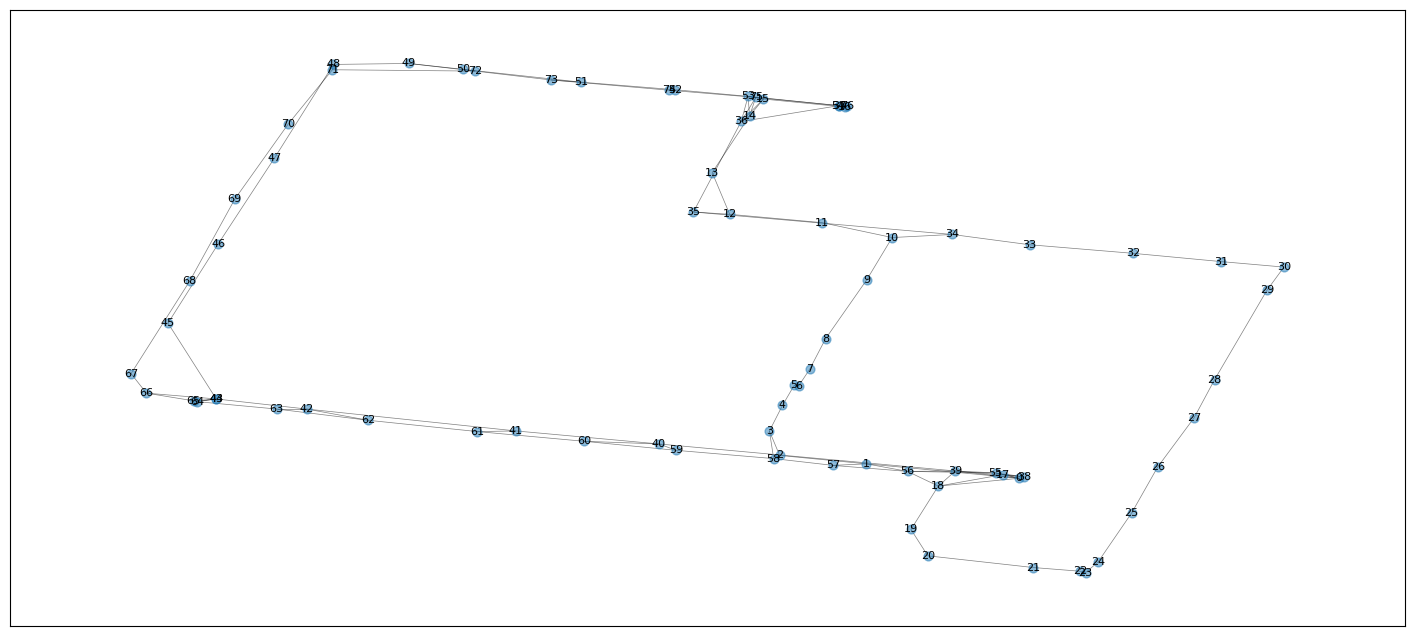

In [519]:
plt.figure(figsize=(18, 8))  
pos = nx.get_node_attributes(combined_graph, 'pos')
nx.draw_networkx_nodes(combined_graph, pos, node_size=40, alpha=0.5 )
nx.draw_networkx_labels(value, pos, labels={node: node for node in combined_graph.nodes()}, font_size=8, font_color='k')
nx.draw_networkx_edges(combined_graph, pos, width=0.5, alpha=0.5)
plt.show()

### 3. Camino de tiempo mínimo y visualización del grafo final

Indicar nodo inicial y nodo final para encontrar el camino de menor tiempo

In [526]:
# Nodo inicial y final
node_i = 8
node_f = 27

# Shortest path
path = nx.shortest_path(combined_graph, source=node_i, target=node_f, weight='time', method= 'dijkstra')

# Calculate the total time for the shortest path
total_time = sum(combined_graph[u][v]['time'] for u, v in zip(path[:-1], path[1:]))

print('El tiempo mínimo del nodo {} al nodo {} es de {} segundos'.format(node_i,node_f,total_time))

El tiempo mínimo del nodo 8 al nodo 27 es de 573.509965862649 segundos


Visualización grafo con el camino de menor tiempo

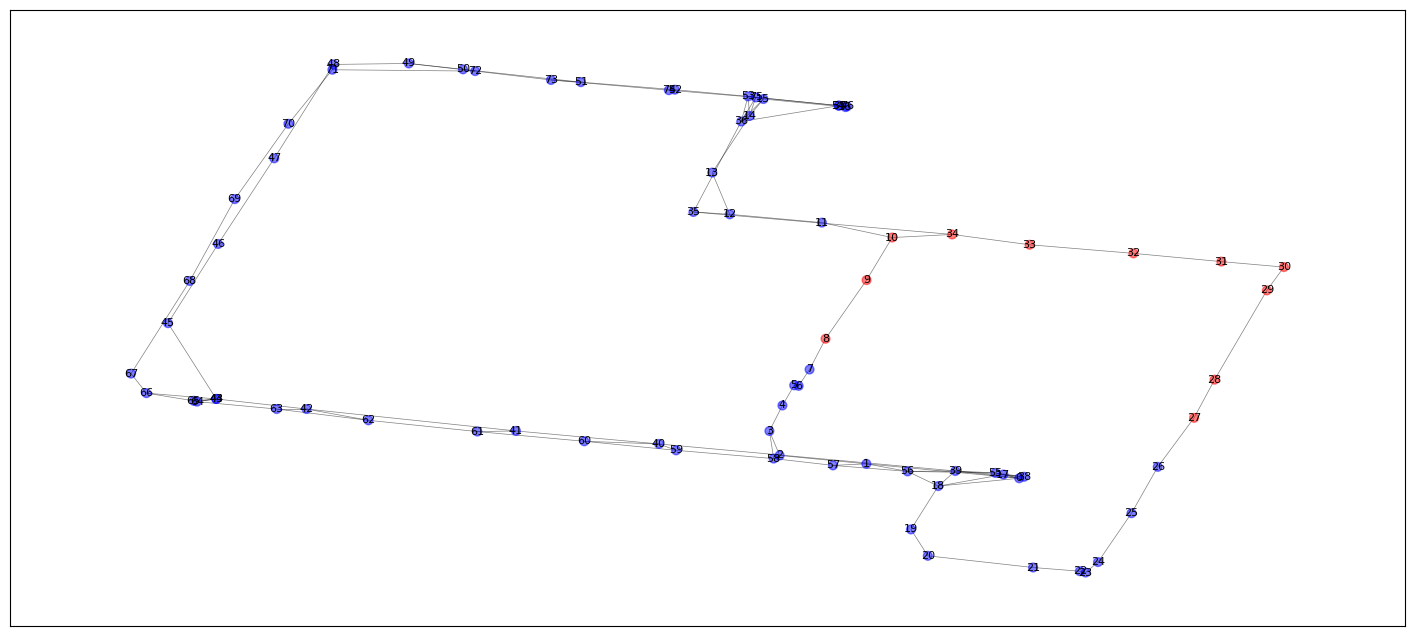

In [527]:
# Diccionario de camino de menor tiempo
node_colors = {node: 'r' if node in path else 'b' for node in combined_graph.nodes()}

plt.figure(figsize=(18, 8))  
pos = nx.get_node_attributes(combined_graph, 'pos')
nx.draw_networkx_nodes(combined_graph, pos, node_size=40, alpha=0.5 , node_color=node_colors.values())
nx.draw_networkx_labels(value, pos, labels={node: node for node in combined_graph.nodes()}, font_size=8, font_color='k')
nx.draw_networkx_edges(combined_graph, pos, width=0.5, alpha=0.5)
plt.show()

### Notas Varias:
- Por falta de especificaciones se asume que todas las direcciones son válidas, si se mencionara de forma estricta que solo hay una dirección se construye el grafo indicando solo en la direción del vehiculo al momento de ingresar los edges.
- Para estimar los tiempos entre los nodos de los distintos grafos se calculo la velocidad promedio entre el nodo con su nodo anterior y el nodo siguiente. 